# Jolideco Analysis of Fermi-LAT data of Vela Junior 

In [1]:
import numpy as np
from pathlib import Path
from matplotlib import pyplot as plt
from astropy.visualization import simple_norm
from astropy import units as u
from jolideco.core import MAPDeconvolver
from jolideco.models import (
    SpatialFluxComponent,
    FluxComponents,
    NPredModels,
    NPredCalibration,
    NPredCalibrations
)
from jolideco.priors import GMMPatchPrior, GaussianMixtureModel
from jolideco.utils.norms import IdentityImageNorm
from scipy.ndimage import gaussian_filter
from itertools import zip_longest
from gammapy.catalog import SourceCatalog3FHL, SourceCatalog4FGL
from regions import CircleSkyRegion

In [2]:
fermi_3fhl = SourceCatalog3FHL()
fermi_4fgl = SourceCatalog4FGL()

In [3]:
vela_junior_3fhl = fermi_3fhl["RX J0852.0-4622"]

In [4]:
if "snakemake" in globals():
    filename_datasets = snakemake.input.filename_datasets
    filename_models = snakemake.input.filename_model
    filename_results = snakemake.output.filename_results
else:
    PATH_BASE = Path("../../results/vela-junior-above-10GeV-data/")
    filename_datasets = PATH_BASE / "datasets/vela-junior-above-10GeV-data-datasets-all.yaml"
    filename_models = PATH_BASE / "model/vela-junior-above-10GeV-data-model.yaml"
    filename_results = PATH_BASE / "jolideco/vela-junior-above-10GeV-data-result-jolideco.fits"

## Counts

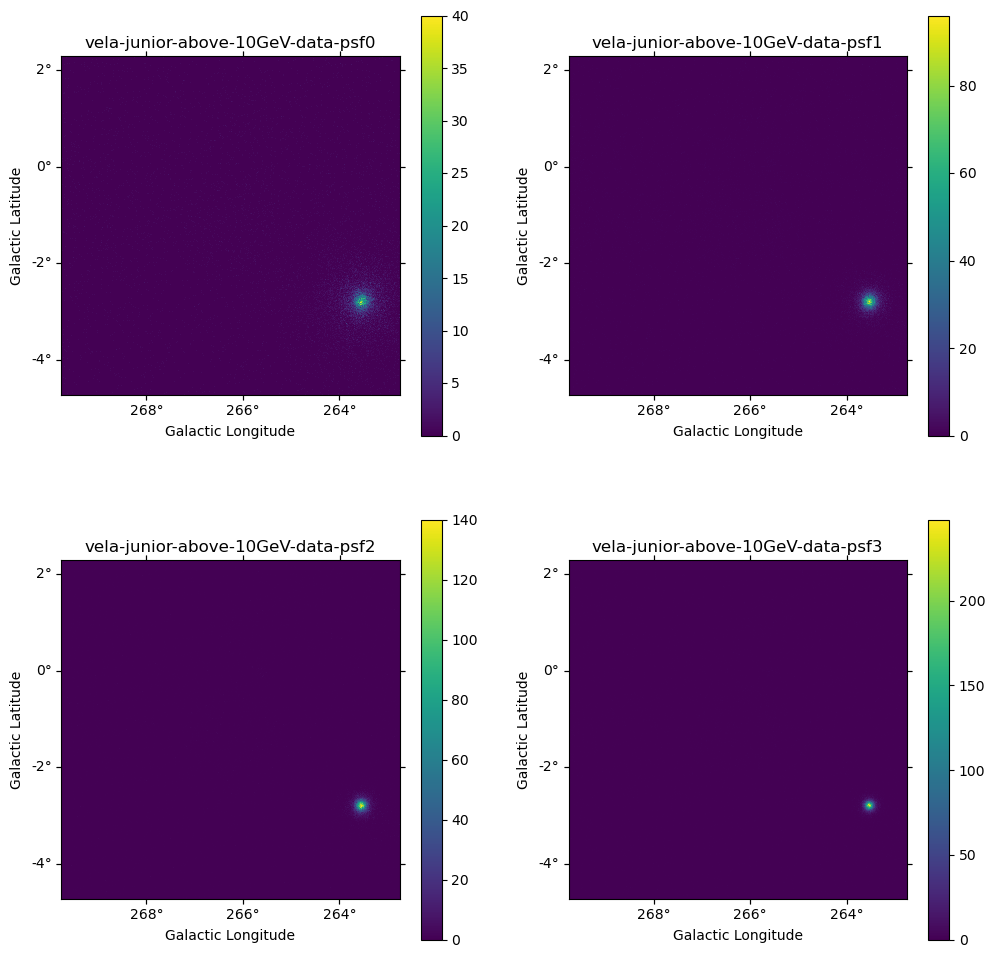

In [12]:
wcs = datasets[0].counts.geom.wcs

fig, axes = plt.subplots(
    ncols=2,
    nrows=2,
    subplot_kw={"projection": wcs},
    figsize=(12, 12)
)

for ax, dataset in zip(axes.flat, datasets):
    counts = dataset.counts.sum_over_axes()
    counts.plot(ax=ax, cmap="viridis", add_cbar=True)
    ax.set_title(f"{dataset.name}")

## Background

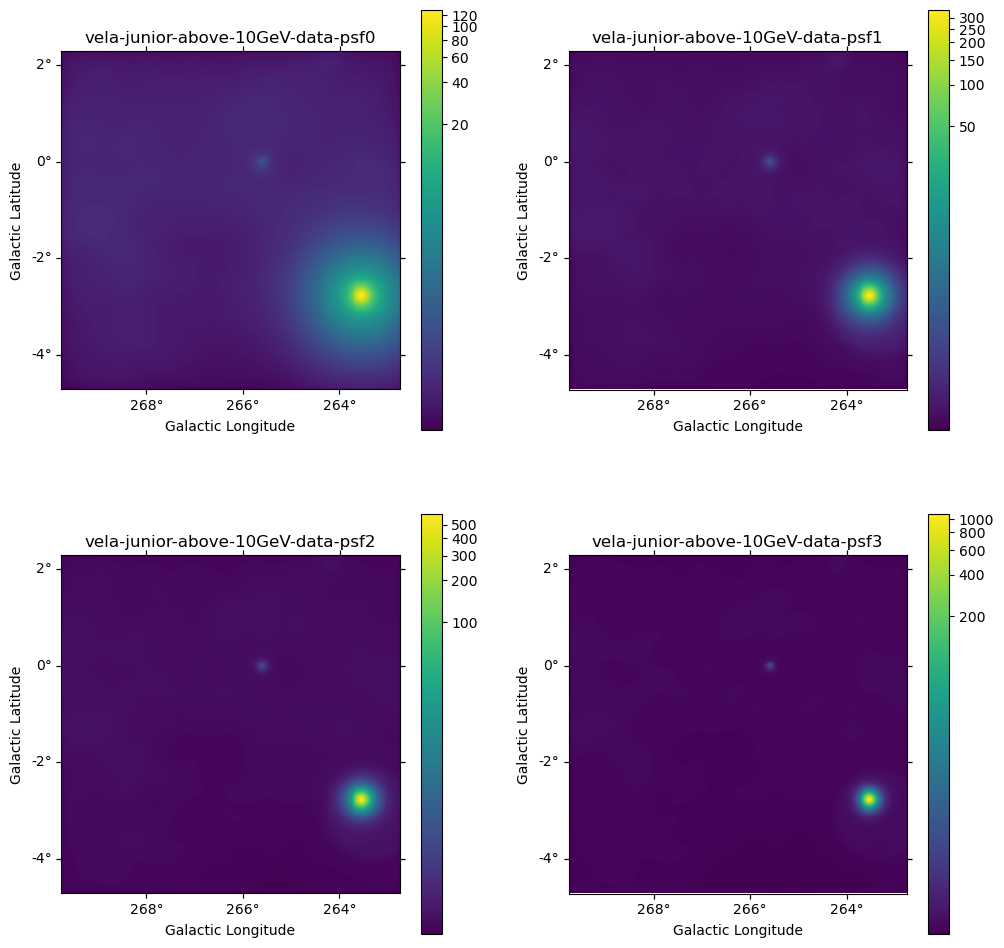

In [13]:
wcs = datasets[0].counts.geom.wcs

fig, axes = plt.subplots(
    ncols=2,
    nrows=2,
    subplot_kw={"projection": wcs},
    figsize=(12, 12)
)

for ax, dataset in zip(axes.flat, datasets):
    npred = dataset.npred().sum_over_axes()
    npred.plot(ax=ax, stretch="log", cmap="viridis", add_cbar=True)
    ax.set_title(f"{dataset.name}")

## PSF

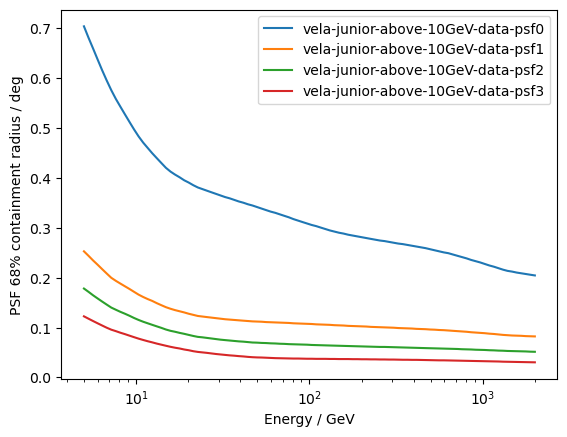

In [14]:
ax = plt.subplot()

energy_true = np.geomspace(5 * u.GeV, 2000 * u.GeV, 100)

for dataset in datasets:
    radius = dataset.psf.containment_radius(
        position=vela_junior_3fhl.position, energy_true=energy_true, fraction=0.68
    )
    ax.plot(energy_true, radius, label=dataset.name)

ax.set_xlabel("Energy / GeV")
ax.set_ylabel("PSF 68% containment radius / deg")
plt.semilogx()
plt.legend();

# Fit Background Level

CPU times: user 11.2 s, sys: 1.71 s, total: 12.9 s
Wall time: 13.3 s


OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 60
	total stat : 263404.72

CovarianceResult

	backend    : minuit
	method     : hesse
	success    : True
	message    : Hesse terminated successfully.

In [20]:
background_norm = datasets.models["diffuse-iem"].spectral_model.norm.value
print(f"Bkg. norm: {background_norm}")

Bkg. norm: 0.23046025553060395


## Run Jolideco

In [30]:
gmm = GaussianMixtureModel.from_registry("chandra-snrs-v0.1")
gmm.stride = 4
print(gmm)

GaussianMixtureModel
--------------------

  type                  : chandra-snrs-v0.1



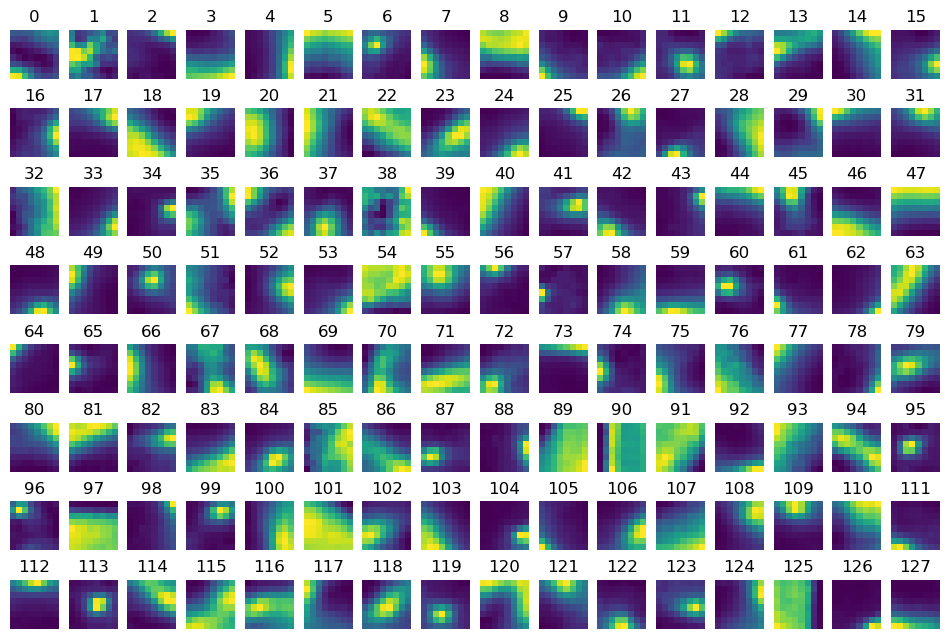

In [98]:
gmm.plot_mean_images(ncols=16, figsize=(12, 8))

In [1]:
patch_prior = GMMPatchPrior(
    gmm=gmm,
    cycle_spin=True,
    stride=4,
    norm=IdentityImageNorm()
)


shape = datasets_jolideco["vela-junior-above-10GeV-data-psf1"]["counts"].shape
flux_init = np.random.normal(loc=0.1, scale=0.01, size=shape).astype(np.float32)

component = SpatialFluxComponent.from_numpy(
    flux=flux_init,
    prior=patch_prior,
    use_log_flux=True,
    upsampling_factor=1,
)


components = FluxComponents()
components["vela-junior"] = component

print(components)

NameError: name 'GMMPatchPrior' is not defined

In [180]:
calibrations = NPredCalibrations()

for name, value in zip(datasets.names, [0.5, 1.2, 1.2, 1.2]):
    calibration = NPredCalibration(background_norm=value, frozen=False)
    calibrations[name] = calibration

print(calibrations)

NPredCalibrations
-----------------

  vela-junior-above-10GeV-data-psf0: 

    shift_x             : 0.000
    shift_y             : 0.000
    background_norm     : 0.500
    frozen              : False

  vela-junior-above-10GeV-data-psf1: 

    shift_x             : 0.000
    shift_y             : 0.000
    background_norm     : 1.200
    frozen              : False

  vela-junior-above-10GeV-data-psf2: 

    shift_x             : 0.000
    shift_y             : 0.000
    background_norm     : 1.200
    frozen              : False

  vela-junior-above-10GeV-data-psf3: 

    shift_x             : 0.000
    shift_y             : 0.000
    background_norm     : 1.200
    frozen              : False




In [181]:
calibrations["vela-junior-above-10GeV-data-psf0"].shift_xy.requires_grad = False

In [182]:
print(calibrations)

NPredCalibrations
-----------------

  vela-junior-above-10GeV-data-psf0: 

    shift_x             : 0.000
    shift_y             : 0.000
    background_norm     : 0.500
    frozen              : False

  vela-junior-above-10GeV-data-psf1: 

    shift_x             : 0.000
    shift_y             : 0.000
    background_norm     : 1.200
    frozen              : False

  vela-junior-above-10GeV-data-psf2: 

    shift_x             : 0.000
    shift_y             : 0.000
    background_norm     : 1.200
    frozen              : False

  vela-junior-above-10GeV-data-psf3: 

    shift_x             : 0.000
    shift_y             : 0.000
    background_norm     : 1.200
    frozen              : False




In [183]:
deconvolve = MAPDeconvolver(n_epochs=500, learning_rate=0.1)
print(deconvolve)

MAPDeconvolver
--------------

  n_epochs              : 500
  beta                  : 1
  learning_rate         : 0.100
  compute_error         : False
  stop_early            : False
  stop_early_n_average  : 10
  device                : cpu



In [184]:
#datasets_jolideco.pop("vela-junior-above-10GeV-data-psf0")

In [185]:
result = deconvolve.run(
    datasets=datasets_jolideco,
    components=components,
    calibrations=calibrations
)

  0%|          | 0/500 [00:00<?, ?it/s]

/Users/adonath/software/mambaforge/envs/jolideco-fermi-examples/lib/python3.9/site-packages/torch/nn/functional.py:4289: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
/Users/adonath/software/mambaforge/envs/jolideco-fermi-examples/lib/python3.9/site-packages/torch/nn/functional.py:4289: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


<Axes: xlabel='# Iteration', ylabel='Loss value'>

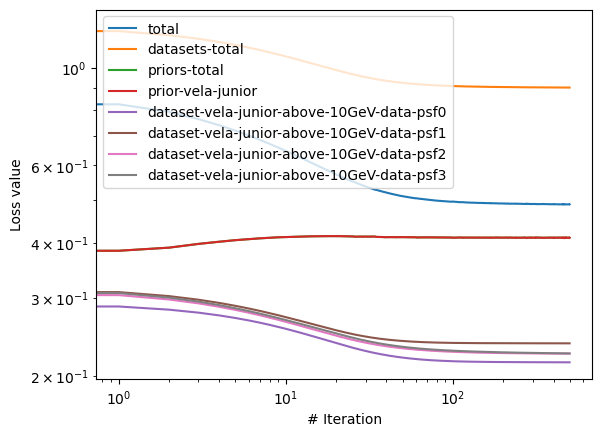

In [186]:
result.plot_trace_loss()

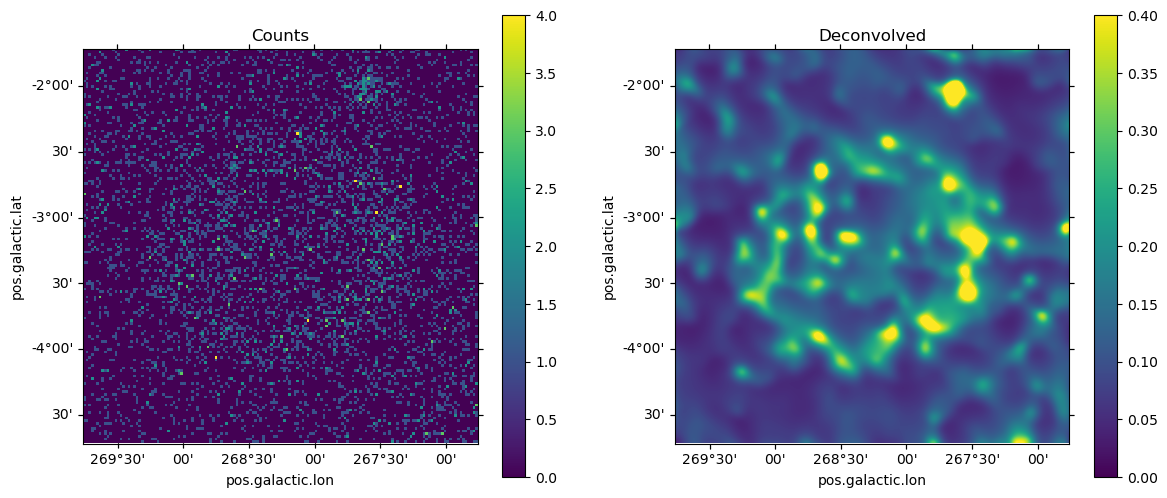

In [187]:
counts = np.sum([_["counts"] for _ in datasets_jolideco.values()], axis=0)

fig, axes = plt.subplots(
    ncols=2,
    subplot_kw={"projection": wcs},
    figsize=(14, 6)
)

norm_asinh = simple_norm(
    counts,
    min_cut=0,
    max_cut=0.4,
    stretch="power",
    power=1.,
)


norm = simple_norm(
    counts,
    min_cut=0.02,
    max_cut=0.3,
    stretch="power",
    power=3
)

im = axes[0].imshow(counts, origin="lower", interpolation="None")
axes[0].set_title("Counts")
plt.colorbar(im);

im = axes[1].imshow(result.components.flux_total_numpy, origin="lower", norm=norm_asinh, interpolation="bicubic")
axes[1].set_title("Deconvolved");
plt.colorbar(im);


In [166]:
print(calibrations)

NPredCalibrations
-----------------

  vela-junior-above-10GeV-data-psf0: 

    shift_x             : 0.000
    shift_y             : 0.000
    background_norm     : 0.069
    frozen              : False

  vela-junior-above-10GeV-data-psf1: 

    shift_x             : -0.506
    shift_y             : -1.883
    background_norm     : 0.191
    frozen              : False

  vela-junior-above-10GeV-data-psf2: 

    shift_x             : -0.011
    shift_y             : 1.176
    background_norm     : 0.164
    frozen              : False

  vela-junior-above-10GeV-data-psf3: 

    shift_x             : -0.080
    shift_y             : -0.068
    background_norm     : 0.137
    frozen              : False




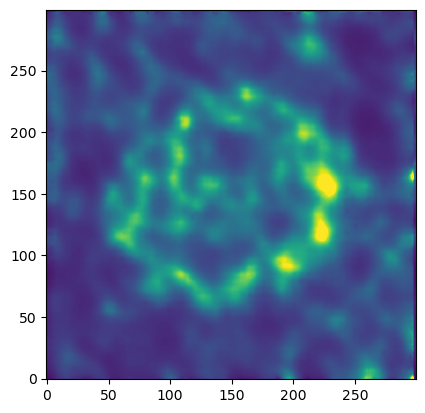

In [172]:
result.components["vela-junior"].plot(interpolation="bicubic", kwargs_norm={"min_cut": 0, "max_cut": 0.1});

In [77]:
from gammapy.maps import Map, WcsGeom

In [71]:
geom = datasets[0].counts.geom.to_image().cutout(**cutout_kwargs)

In [72]:
flux = Map.from_geom(geom, data=component.flux_numpy)

In [78]:
geom_icrc = WcsGeom.create(
    skydir=geom.center_skydir,
    width=3 * u.deg,
    binsz=0.02
)

In [79]:
flux_icrs = flux.interp_to_geom(geom_icrc)

<WCSAxes: >

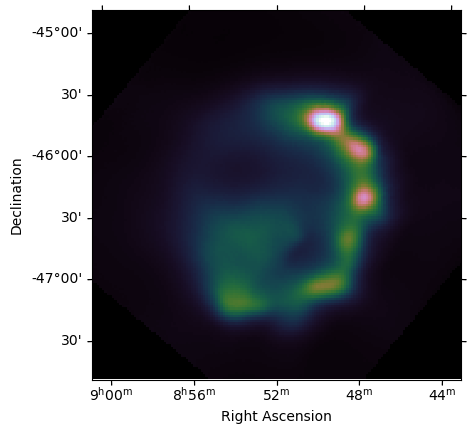

In [96]:
norm_pwr = simple_norm(
    flux.data,
    min_cut=0,
    max_cut=0.35,
    stretch="power",
    power=1.3,
)
flux_icrs.plot(cmap="cubehelix", norm=norm_pwr)

In [51]:
print(patch_prior.norm)

IdentityImageNorm
-----------------

  type                  : identity



In [52]:
print(calibrations)

NPredCalibrations
-----------------

  vela-junior-above-10GeV-data-psf0: 

    shift_x             : -1.923
    shift_y             : -0.503
    background_norm     : 0.106
    frozen              : False

  vela-junior-above-10GeV-data-psf1: 

    shift_x             : -0.112
    shift_y             : -1.353
    background_norm     : 0.256
    frozen              : False

  vela-junior-above-10GeV-data-psf2: 

    shift_x             : -0.108
    shift_y             : 0.954
    background_norm     : 0.230
    frozen              : False

  vela-junior-above-10GeV-data-psf3: 

    shift_x             : 0.052
    shift_y             : -0.011
    background_norm     : 0.211
    frozen              : False




In [43]:
result.write(filename_results, overwrite=True)

INFO:jolideco.utils.io.fits:writing ../../results/vela-junior-above-10GeV-data/jolideco/vela-junior-above-10GeV-data-result-jolideco.fits


In [44]:
npreds = {}

for name, dataset in datasets_jolideco.items():
    model = NPredModels.from_dataset_numpy(
        dataset=dataset,
        components=result.components,
    )
    
    fluxes = result.components.to_flux_tuple()
    npred = model.evaluate(fluxes=fluxes).detach().numpy()[0, 0]
    npreds[name] = npred
    

npreds_calibrated = {}

for name, dataset in datasets_jolideco.items():
    model = NPredModels.from_dataset_numpy(
        dataset=dataset,
        components=result.components,
        calibration=calibrations[name]
    )
    
    fluxes = result.components.to_flux_tuple()
    npred = model.evaluate(fluxes=fluxes).detach().numpy()[0, 0]
    npreds_calibrated[name] = npred
    

/Users/adonath/software/mambaforge/envs/jolideco-fermi-examples/lib/python3.9/site-packages/torch/nn/functional.py:4289: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


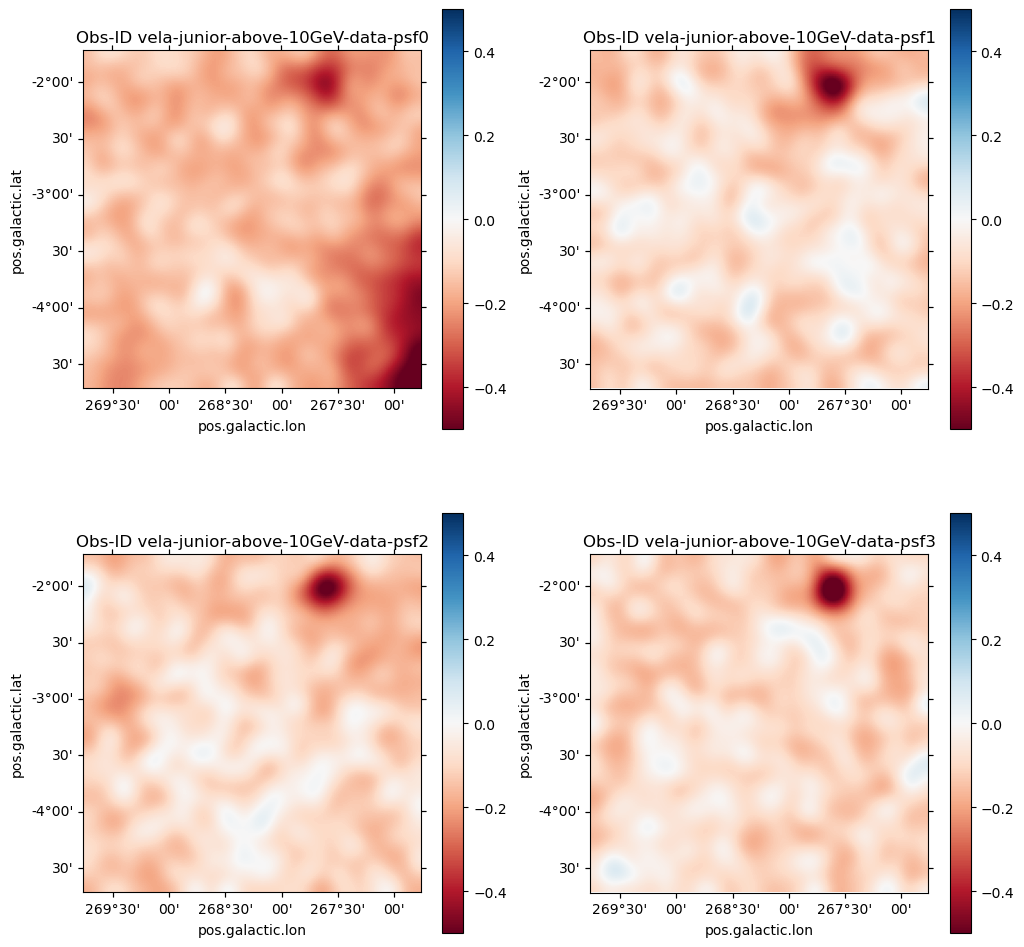

In [45]:
fig, axes = plt.subplots(
    ncols=2,
    nrows=2,
    subplot_kw={"projection": wcs},
    gridspec_kw={"wspace": 0.2},
    figsize=(12, 12)
)


for name, ax in zip_longest(datasets_jolideco, axes.flat):
    if name is None:
        ax.set_visible(False)
        continue
        
    dataset = datasets_jolideco[name]
    
    residual = (dataset["counts"] - npreds[name]) / np.sqrt(npreds[name])
    smoothed = gaussian_filter(residual, 5)
    
    im = ax.imshow(smoothed, vmin=-0.5, vmax=0.5, cmap="RdBu")
    ax.set_title(f"Obs-ID {name}")
    plt.colorbar(im, ax=ax)

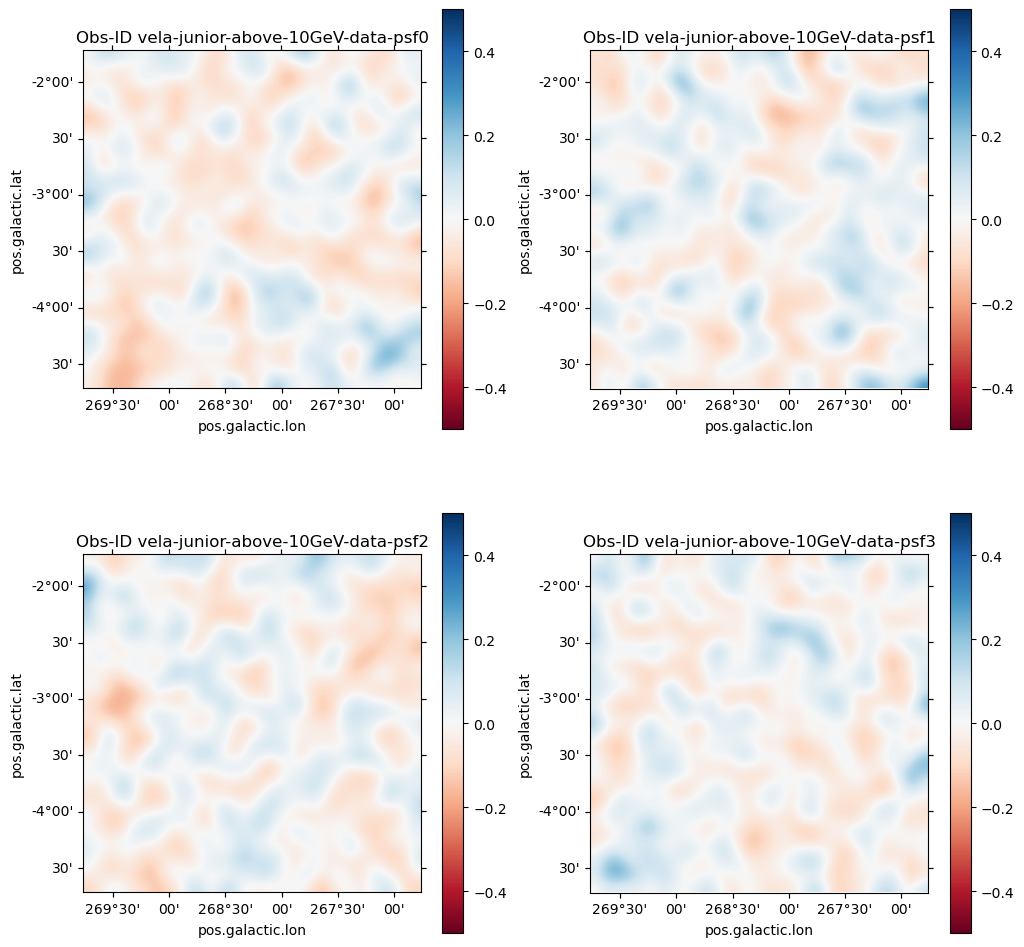

In [46]:
fig, axes = plt.subplots(
    ncols=2,
    nrows=2,
    subplot_kw={"projection": wcs},
    gridspec_kw={"wspace": 0.2},
    figsize=(12, 12)
)


for name, ax in zip_longest(datasets_jolideco, axes.flat):
    if name is None:
        ax.set_visible(False)
        continue
        
    dataset = datasets_jolideco[name]
    
    residual = (dataset["counts"] - npreds_calibrated[name]) / np.sqrt(npreds_calibrated[name])
    smoothed = gaussian_filter(residual, 5)
    
    im = ax.imshow(smoothed, vmin=-0.5, vmax=0.5, cmap="RdBu")
    ax.set_title(f"Obs-ID {name}")
    plt.colorbar(im, ax=ax)

In [47]:
print(calibrations)

NPredCalibrations
-----------------

  vela-junior-above-10GeV-data-psf0: 

    shift_x             : -1.923
    shift_y             : -0.503
    background_norm     : 0.106
    frozen              : False

  vela-junior-above-10GeV-data-psf1: 

    shift_x             : -0.112
    shift_y             : -1.353
    background_norm     : 0.256
    frozen              : False

  vela-junior-above-10GeV-data-psf2: 

    shift_x             : -0.108
    shift_y             : 0.954
    background_norm     : 0.230
    frozen              : False

  vela-junior-above-10GeV-data-psf3: 

    shift_x             : 0.052
    shift_y             : -0.011
    background_norm     : 0.211
    frozen              : False


